## Modified 


In [57]:
# Q5 – Notebook 2: Modified Dataset Split
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [58]:
# Each image is subjected to a transform pipeline:
#-resize to 224x224 (the typical ResNet input size) 
#-convert NumPy array → PIL picture 
#-randomly flip horizontally for data augmentation
#: transform to a tensor
#: Use ImageNet mean and standard deviation to standardize
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [59]:
#To leverage the NumPy picture arrays and labels with a PyTorch DataLoader, we need to create a custom dataset.
class NumpyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.reshape(-1).astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label, index


In [60]:
# Aids in loading the HDF5 file's cat vs. non-cat dataset.
#  Only the original training file, 
# is used in this updated notebook. Based on the assignment rule, we then generate a new train/test split.
def load_cat_dataset(train_path, test_path=None):
    with h5py.File(train_path, "r") as train_file:
        train_images = train_file["train_set_x"][:]
        train_labels = train_file["train_set_y"][:]
        class_names = train_file["list_classes"][:]
        # We ignore test_path here because in this modified version
        # we build our own test set from the training images.
    return train_images, train_labels, None, None, class_names


In [61]:
#During one training epoch, the model is set in train mode, mini-batches are looped over, 
# loss, backprop, and update parameters are computed, and running loss and accuracy are tracked.
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels, indices in data_loader:
        images = images.to(device)
        labels_tensor = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).int().cpu().squeeze(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function (no adjustments to the gradient):
#Put the model in evaluation mode, calculate loss and accuracy, and record all predictions, labels, 
# and indices so that misclassifications may be examined.
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_indices = []

    with torch.no_grad():
        for images, labels, indices in data_loader:
            images = images.to(device)
            labels_tensor = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels_tensor)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int().cpu().squeeze(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.numpy())
            all_labels.append(labels.numpy())
            all_indices.append(indices.numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_indices = np.concatenate(all_indices)

    return epoch_loss, epoch_acc, all_preds, all_labels, all_indices


In [62]:
def show_misclassified(images_raw, mis_indices, true_labels, pred_labels, num_to_show=4):
    num_to_show = min(num_to_show, len(mis_indices))
    if num_to_show == 0:
        print("No misclassified images.")
        return

    plt.figure(figsize=(12, 3))
    for i in range(num_to_show):
        idx = mis_indices[i]
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(images_raw[idx].astype(np.uint8))
        plt.axis("off")
        plt.title(f"idx {idx}\ntrue={true_labels[idx]}, pred={pred_labels[idx]}")
    plt.tight_layout()
    plt.show()


In [63]:
#In accordance with the assignment's "160 + last digit" criteria, we manually divide all training pictures and labels into a new train + test set after loading them from the HDF5 file.
train_images_all, train_labels_all, _, _, class_names = load_cat_dataset(
    "train_catvnoncat.h5"
)

print("Original train set shape:", train_images_all.shape)


Original train set shape: (209, 64, 64, 3)


In [64]:
# According to the homework instructions:

last_digit = 6  # SBU id last digit is 6

new_train_count = 160 + last_digit
new_train_images = train_images_all[:new_train_count]
new_train_labels = train_labels_all[:new_train_count]

new_test_images = train_images_all[new_train_count:]
new_test_labels = train_labels_all[new_train_count:]

print("New train size:", new_train_images.shape[0])
print("New test size :", new_test_images.shape[0])


New train size: 166
New test size : 43


In [65]:
#To facilitate training and evaluation with mini-batches, wrap the NumPy arrays with our own Dataset and DataLoader.
new_train_dataset = NumpyImageDataset(new_train_images, new_train_labels, transform=transform)
new_test_dataset = NumpyImageDataset(new_test_images, new_test_labels, transform=transform)

new_train_loader = DataLoader(new_train_dataset, batch_size=16, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=16, shuffle=False)


In [66]:
#For this updated split, we develop a fresh ResNet18 model and optimizer, 
# so no weights from any prior notebook are used during training.
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)

model = model.to(device)


/Users/rishabhgosain/Documents/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rishabhgosain/Documents/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
# Following training, assess performance independently on: 
# new training set # - new test set (remaining original training pictures)
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, new_train_loader, criterion, optimizer, device
    )
    scheduler.step()
    print(f"Epoch {epoch+1:02d}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch 01/5 - Train Loss: 0.7010, Train Acc: 0.5542
Epoch 02/5 - Train Loss: 0.5252, Train Acc: 0.7892
Epoch 03/5 - Train Loss: 0.4334, Train Acc: 0.8795
Epoch 04/5 - Train Loss: 0.3505, Train Acc: 0.9518
Epoch 05/5 - Train Loss: 0.3025, Train Acc: 0.9277


In [68]:
# Following training, assess performance independently on: 
# new training set # - new test set (remaining original training pictures)
train_loss, train_acc, train_preds, train_true, train_idx = evaluate_model(
    model, new_train_loader, criterion, device
)
test_loss, test_acc, test_preds, test_true, test_idx = evaluate_model(
    model, new_test_loader, criterion, device
)

print("\nFinal Training Accuracy (modified split):", train_acc)
print("Final Test Accuracy (modified split):     ", test_acc)

print("\nClassification report on NEW TEST set:")
print(classification_report(test_true, test_preds, digits=4))



Final Training Accuracy (modified split): 0.9698795180722891
Final Test Accuracy (modified split):      0.8604651162790697

Classification report on NEW TEST set:
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        30
           1     0.7333    0.8462    0.7857        13

    accuracy                         0.8605        43
   macro avg     0.8310    0.8564    0.8411        43
weighted avg     0.8695    0.8605    0.8630        43



Indices of misclassified images in NEW test set:
[1, 12, 19, 31, 39, 41]


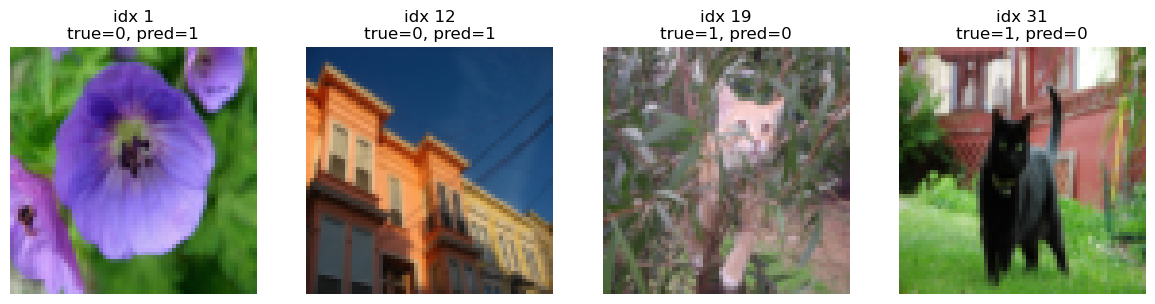

In [69]:
#Determine which of the NEW test set's instances were incorrectly categorized, print their indices, and display a handful of them.
mis_mask_new = test_preds != test_true
mis_indices_new = test_idx[mis_mask_new]

print("Indices of misclassified images in NEW test set:")
print(mis_indices_new.tolist())

show_misclassified(
    images_raw=new_test_images,
    mis_indices=mis_indices_new,
    true_labels=test_true,
    pred_labels=test_preds,
    num_to_show=4
)